<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/S6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gremlin97/EVA-Utils

Cloning into 'EVA-Utils'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 121 (delta 67), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (121/121), 30.12 KiB | 5.02 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
%cd EVA-Utils/models

/content/EVA-Utils/models


In [3]:
%matplotlib inline

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from custom_cnn import *

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_height=16, min_width=16, min_holes = 1, fill_value=-1.69, mask_fill_value = None),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

test_transform = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_height=16, min_width=16, min_holes = 1, fill_value=-1.69, mask_fill_value = None),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

class Cifar10(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

trainset = Cifar10(root='./data', train=True,download=True, transform=train_transform)
testset = Cifar10(root='./data', train=False,download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



  cat  frog plane   car


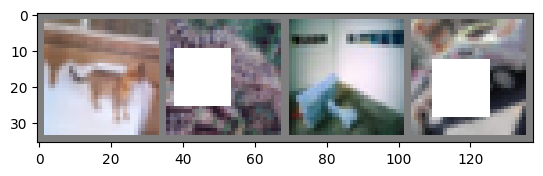

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(iter(dataiter))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
net = Net()

In [8]:
out = net(torch.randn(1,3,32,32))

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
from torchsummary import summary
summary(net.to(device),input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]           1,216
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 16, 15, 15]           2,320
              ReLU-5           [-1, 16, 15, 15]               0
       BatchNorm2d-6           [-1, 16, 15, 15]              32
            Conv2d-7           [-1, 32, 15, 15]           4,640
              ReLU-8           [-1, 32, 15, 15]               0
       BatchNorm2d-9           [-1, 32, 15, 15]              64
           Conv2d-10           [-1, 64, 15, 15]             640
             ReLU-11           [-1, 64, 15, 15]               0
      BatchNorm2d-12           [-1, 64, 15, 15]             128
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [12]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.138
[1,  4000] loss: 2.000
[1,  6000] loss: 1.939
[1,  8000] loss: 1.895
[1, 10000] loss: 1.860
[1, 12000] loss: 1.818
[2,  2000] loss: 1.800
[2,  4000] loss: 1.773
[2,  6000] loss: 1.729
[2,  8000] loss: 1.714
[2, 10000] loss: 1.708
[2, 12000] loss: 1.689
[3,  2000] loss: 1.693
[3,  4000] loss: 1.644
[3,  6000] loss: 1.627
[3,  8000] loss: 1.638
[3, 10000] loss: 1.605
[3, 12000] loss: 1.595
[4,  2000] loss: 1.600
[4,  4000] loss: 1.550
[4,  6000] loss: 1.549
[4,  8000] loss: 1.550
[4, 10000] loss: 1.513
[4, 12000] loss: 1.537
[5,  2000] loss: 1.510
[5,  4000] loss: 1.499
[5,  6000] loss: 1.459
[5,  8000] loss: 1.480
[5, 10000] loss: 1.460
[5, 12000] loss: 1.453
[6,  2000] loss: 1.449
[6,  4000] loss: 1.433
[6,  6000] loss: 1.444
[6,  8000] loss: 1.438
[6, 10000] loss: 1.407
[6, 12000] loss: 1.396
[7,  2000] loss: 1.378
[7,  4000] loss: 1.397
[7,  6000] loss: 1.387
[7,  8000] loss: 1.397
[7, 10000] loss: 1.385
[7, 12000] loss: 1.374
[8,  2000] loss: 1.339
[8,  4000] 

GroundTruth:   ship   cat  frog  bird


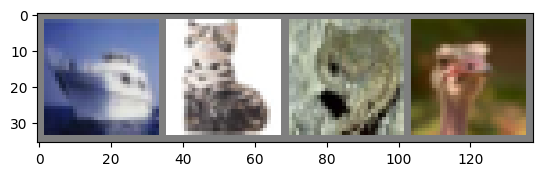

In [13]:
dataiter = iter(testloader)
images, labels = next(iter(dataiter))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   cat  frog  bird


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 91 %
Accuracy of  bird : 62 %
Accuracy of   cat : 68 %
Accuracy of  deer : 70 %
Accuracy of   dog : 63 %
Accuracy of  frog : 73 %
Accuracy of horse : 78 %
Accuracy of  ship : 78 %
Accuracy of truck : 75 %
